Собянин Максим, РИ-411003

In [1]:
ls

sample_data/  skab_valve_1.csv


##Данные

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Загрузка данных
data = pd.read_csv('skab_valve_1.csv', sep=';')
data['datetime'] = pd.to_datetime(data['datetime'])

##Статистические эвристики

###Визуализируйте ряд, пометив аномальные точки - anomaly = 1

Визуализируем Accelerometer1RMS, и отметим аномальные точки (anomaly = 1).

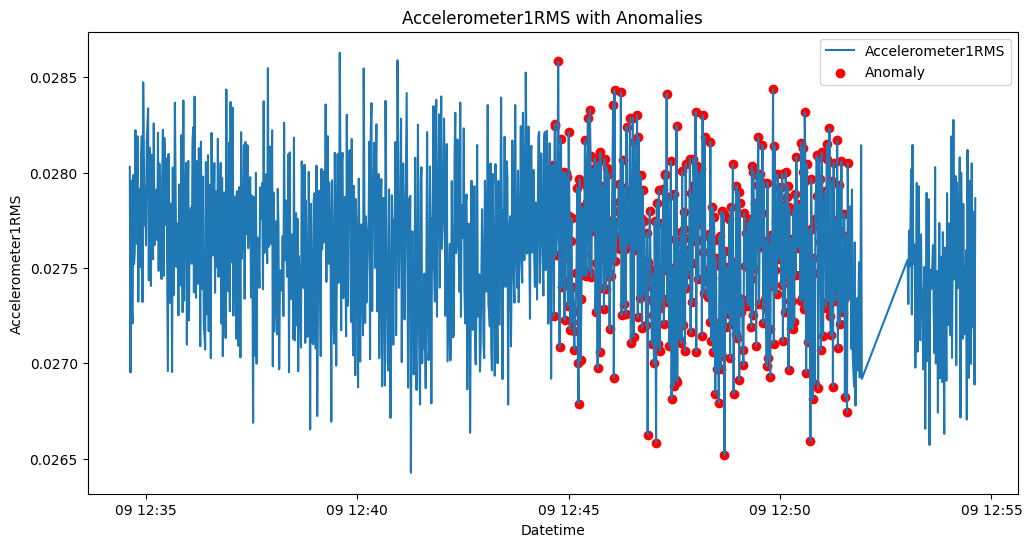

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(data['datetime'], data['Accelerometer1RMS'], label='Accelerometer1RMS')
plt.scatter(data[data['anomaly'] == 1]['datetime'],
            data[data['anomaly'] == 1]['Accelerometer1RMS'],
            color='red', label='Anomaly')
plt.xlabel('Datetime')
plt.ylabel('Accelerometer1RMS')
plt.legend()
plt.title('Accelerometer1RMS with Anomalies')
plt.show()


###Реализуйте фильтрацию аномалий на основе расчитанных статистик [Q1 - (1.5 * IQR), Q3 + (1.5 * IQR)], [Q1 - (3 * IQR), Q3 + (3 * IQR)]

Для фильтрации аномалий создадим два набора границ:

Стандартные границы: [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR]
Более строгие границы: [Q1 - 3 * IQR, Q3 + 3 * IQR]
Используем столбец Accelerometer1RMS для расчета.

In [4]:
def detect_anomalies_iqr(data, column, multiplier=1.5):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return (data[column] < lower_bound) | (data[column] > upper_bound)

# Добавим новые столбцы с результатами фильтрации аномалий
data['anomaly_iqr_1.5'] = detect_anomalies_iqr(data, 'Accelerometer1RMS', 1.5).astype(int)
data['anomaly_iqr_3'] = detect_anomalies_iqr(data, 'Accelerometer1RMS', 3).astype(int)


###Визуализируйте результаты работы модели, оцените качество визуально

Визуализируем результаты фильтрации аномалий по каждому из методов. Отобразим данные и аномальные точки, определенные с помощью двух фильтров.

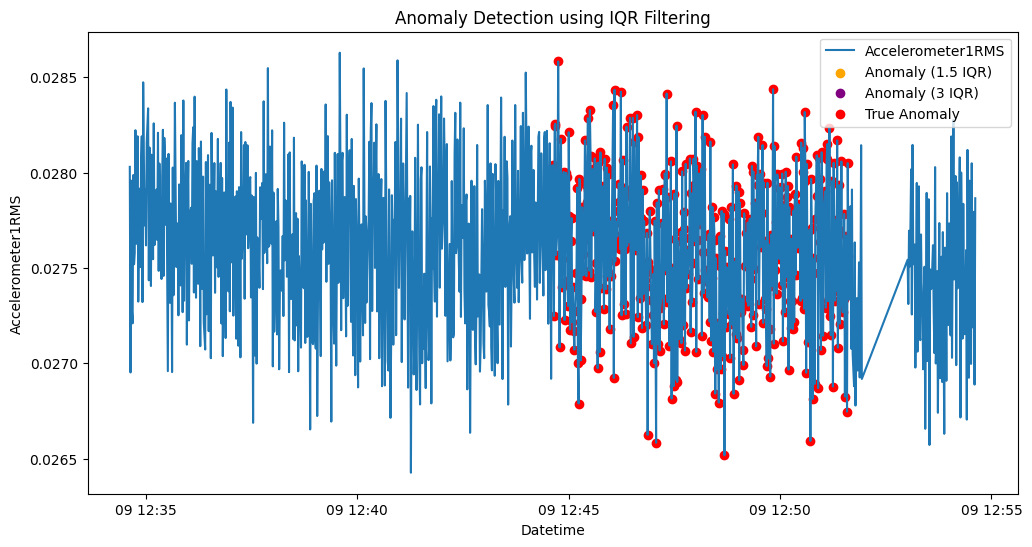

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(data['datetime'], data['Accelerometer1RMS'], label='Accelerometer1RMS')
plt.scatter(data[data['anomaly_iqr_1.5'] == 1]['datetime'],
            data[data['anomaly_iqr_1.5'] == 1]['Accelerometer1RMS'],
            color='orange', label='Anomaly (1.5 IQR)')
plt.scatter(data[data['anomaly_iqr_3'] == 1]['datetime'],
            data[data['anomaly_iqr_3'] == 1]['Accelerometer1RMS'],
            color='purple', label='Anomaly (3 IQR)')
plt.scatter(data[data['anomaly'] == 1]['datetime'],
            data[data['anomaly'] == 1]['Accelerometer1RMS'],
            color='red', label='True Anomaly')
plt.xlabel('Datetime')
plt.ylabel('Accelerometer1RMS')
plt.legend()
plt.title('Anomaly Detection using IQR Filtering')
plt.show()


Данная модель крайне плохо обнаруживает аномалии.

###Оцените качество, построив confusion matrix для предсказаний и исходных данных

Для оценки качества построим confusion matrix для каждого фильтра и сравним их с исходными значениями в anomaly.

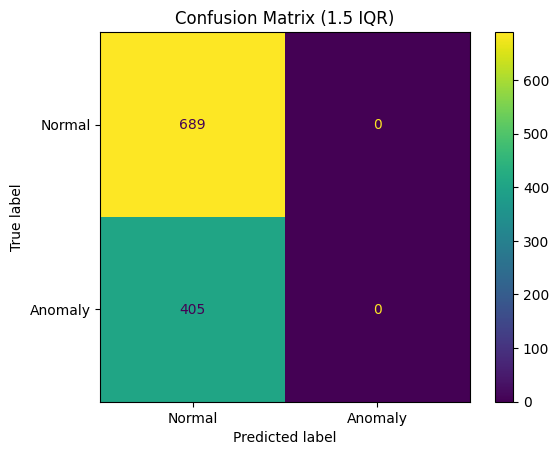

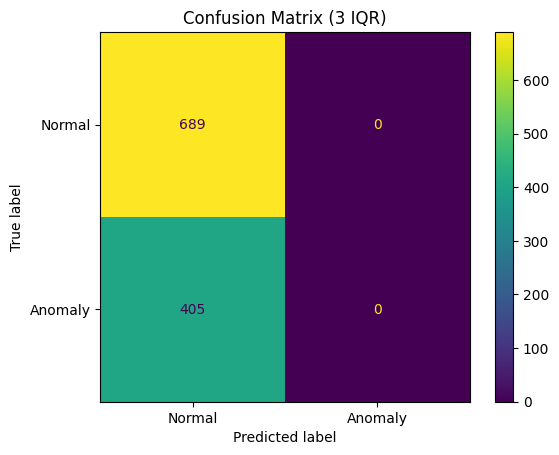

In [6]:
# Confusion matrix для фильтрации с 1.5 * IQR
cm_1_5 = confusion_matrix(data['anomaly'], data['anomaly_iqr_1.5'])
ConfusionMatrixDisplay(cm_1_5, display_labels=['Normal', 'Anomaly']).plot()
plt.title('Confusion Matrix (1.5 IQR)')
plt.show()

# Confusion matrix для фильтрации с 3 * IQR
cm_3 = confusion_matrix(data['anomaly'], data['anomaly_iqr_3'])
ConfusionMatrixDisplay(cm_3, display_labels=['Normal', 'Anomaly']).plot()
plt.title('Confusion Matrix (3 IQR)')
plt.show()


Матрица ошибок:


*   True Negative (TN): 689 — количество правильно предсказанных отрицательных случаев. То есть, модель правильно определила 689 случаев как отрицательные (класс 0).
*   False Positive (FP): 0 — количество неправильно предсказанных положительных случаев. В данном случае модель не ошиблась, не предсказав ни одного случая как положительный (класс 1), когда на самом деле он был отрицательным.
*   False Negative (FN): 405 — количество неправильно предсказанных отрицательных случаев. Это означает, что модель не смогла обнаружить 405 случаев, которые на самом деле были положительными (класс 1), и ошибочно предсказала их как отрицательные.
*   True Positive (TP): 0 — количество правильно предсказанных положительных случаев. В данном случае модель не смогла правильно предсказать ни одного положительного случая.

В нашем случае модель не идентифицировала ни одного положительного случая. Это говорит о проблемах с производительностью.

In [7]:
first_report = classification_report(data['anomaly'], data['anomaly_iqr_1.5'],output_dict=True)
print(first_report)

{'0.0': {'precision': 0.629798903107861, 'recall': 1.0, 'f1-score': 0.7728547392035895, 'support': 689.0}, '1.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 405.0}, 'accuracy': 0.629798903107861, 'macro avg': {'precision': 0.3148994515539305, 'recall': 0.5, 'f1-score': 0.38642736960179475, 'support': 1094.0}, 'weighted avg': {'precision': 0.39664665835586493, 'recall': 0.629798903107861, 'f1-score': 0.48674306701213266, 'support': 1094.0}}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##Кластеризация

###Используйте Feature-Engineering для создания признаков (лаги, скользящие статистики, признаки даты/времени, etc)

Сначала снова инициализируем данные

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

# Загрузим данные
data = pd.read_csv('skab_valve_1.csv', sep=';')
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)

Добавим признаки для анализа:

Лаги: значения с задержкой на 1 и 2 временных шага.
Скользящие статистики: средние и стандартные отклонения с окнами в 3 и 5 шагов.
Признаки даты/времени: час, день недели и месяц.

In [9]:
# Лаги
data['Accelerometer1RMS_lag1'] = data['Accelerometer1RMS'].shift(1)
data['Accelerometer1RMS_lag2'] = data['Accelerometer1RMS'].shift(2)

# Скользящие статистики
data['Accelerometer1RMS_rollmean_3'] = data['Accelerometer1RMS'].rolling(window=3).mean()
data['Accelerometer1RMS_rollstd_3'] = data['Accelerometer1RMS'].rolling(window=3).std()
data['Accelerometer1RMS_rollmean_5'] = data['Accelerometer1RMS'].rolling(window=5).mean()
data['Accelerometer1RMS_rollstd_5'] = data['Accelerometer1RMS'].rolling(window=5).std()

# Временные признаки
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month

# Убираем строки с NaN, которые появились после добавления лагов и скользящих окон
data.dropna(inplace=True)

###Реализуйте фильтрацию аномалий на основе модели кластеризации (можно взять любой алгоритм и библиотеку, которые вам понравились)

Кластеризуем данные, будем считать выбросами точки, принадлежащие кластерам, находящимся далеко от основной массы данных.

In [10]:
# Стандартизация признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[['Accelerometer1RMS', 'Accelerometer2RMS', 'Current',
                                      'Pressure', 'Temperature', 'Thermocouple', 'Voltage',
                                      'Volume Flow RateRMS', 'Accelerometer1RMS_lag1',
                                      'Accelerometer1RMS_lag2', 'Accelerometer1RMS_rollmean_3',
                                      'Accelerometer1RMS_rollstd_3', 'Accelerometer1RMS_rollmean_5',
                                      'Accelerometer1RMS_rollstd_5', 'hour', 'day_of_week', 'month']])

# Кластеризация
kmeans = KMeans(n_clusters=2, random_state=0)
data['cluster'] = kmeans.fit_predict(X_scaled)

# Определение аномалий (можно считать меньший кластер аномальным)
cluster_sizes = data['cluster'].value_counts()
anomaly_cluster = cluster_sizes.idxmin()
data['anomaly_kmeans'] = (data['cluster'] == anomaly_cluster).astype(int)

###Визуализируйте результаты работы модели, оцените качество визуально, Оцените качество, построив confusion matrix для предсказаний и исходных данных

Визуализируем Accelerometer1RMS с отмеченными аномальными точками. Построим confusion matrix.



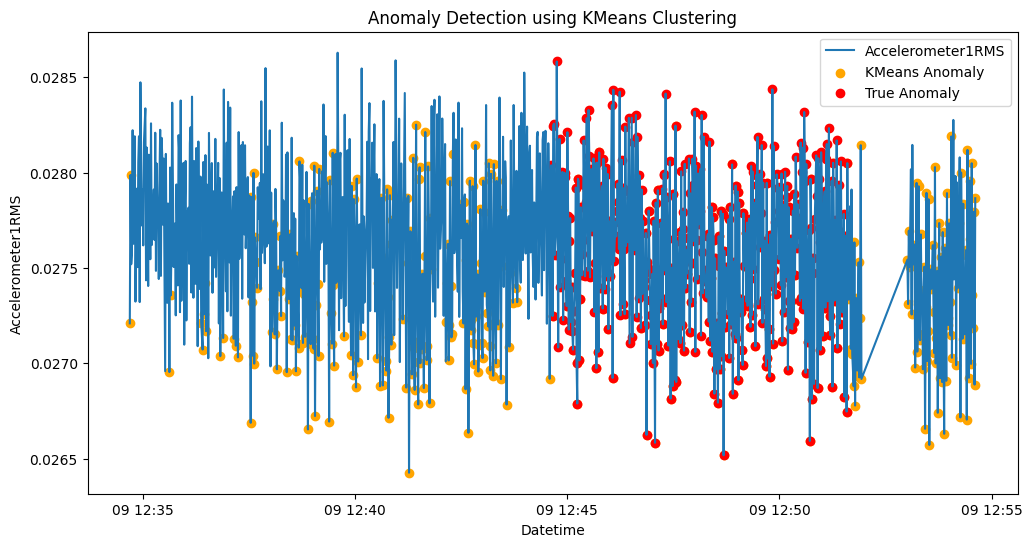

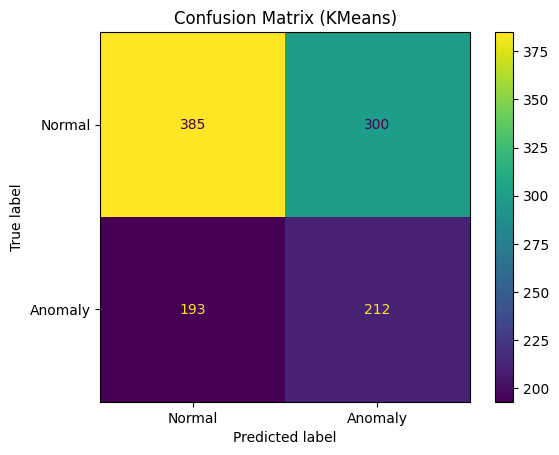

In [11]:
# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Accelerometer1RMS'], label='Accelerometer1RMS')
plt.scatter(data[data['anomaly_kmeans'] == 1].index,
            data[data['anomaly_kmeans'] == 1]['Accelerometer1RMS'],
            color='orange', label='KMeans Anomaly')
plt.scatter(data[data['anomaly'] == 1].index,
            data[data['anomaly'] == 1]['Accelerometer1RMS'],
            color='red', label='True Anomaly')
plt.xlabel('Datetime')
plt.ylabel('Accelerometer1RMS')
plt.legend()
plt.title('Anomaly Detection using KMeans Clustering')
plt.show()

# Confusion matrix
cm_kmeans = confusion_matrix(data['anomaly'], data['anomaly_kmeans'])
ConfusionMatrixDisplay(cm_kmeans, display_labels=['Normal', 'Anomaly']).plot()
plt.title('Confusion Matrix (KMeans)')
plt.show()

Описание матрицы ошибок:


*   True Negative (TN): 385 — количество правильно предсказанных отрицательных случаев. Это хорошие предсказания, так как они соответствуют действительности.
*   False Positive (FP): 300 — количество неправильно предсказанных положительных случаев. Эти ошибки показывают, что модель склонна переоценивать вероятность принадлежности объектов к положительному классу.
*   False Negative (FN): 193 — количество неправильно предсказанных отрицательных случаев. Это означает, что модель не смогла обнаружить 193 случаев, которые на самом деле были положительными (класс 1), и ошибочно предсказала их как отрицательные.
*   True Positive (TP): 212 — количество правильно предсказанных положительных случаев. Это положительные примеры, где классификация была выполнена корректно.

Модель не совсем точна, однако она правильно классифицирует некоторые случаи (TP TN), ошибки в основном связаны с неверной классификацией положительных и отрицательных. Можно заметить, что больше ошибок происходит при классификации в положительные.

In [12]:
second_report = classification_report(data['anomaly'], data['anomaly_kmeans'],output_dict=True)
print(second_report)

{'0.0': {'precision': 0.6660899653979239, 'recall': 0.5620437956204379, 'f1-score': 0.6096595407759303, 'support': 685.0}, '1.0': {'precision': 0.4140625, 'recall': 0.5234567901234568, 'f1-score': 0.4623773173391494, 'support': 405.0}, 'accuracy': 0.5477064220183486, 'macro avg': {'precision': 0.5400762326989619, 'recall': 0.5427502928719474, 'f1-score': 0.5360184290575398, 'support': 1090.0}, 'weighted avg': {'precision': 0.5724467328418145, 'recall': 0.5477064220183486, 'f1-score': 0.5549354118842824, 'support': 1090.0}}


##Isolation Forest

Вновь инициализируем данные

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Загрузим данные
data = pd.read_csv('skab_valve_1.csv', sep=';')
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)

###Реализуйте фильтрацию аномалий на основе модели Isolation Forest

IsolationForest чувствителен к масштабированию данных, нужно стандартизировать числовые признаки:

Accelerometer1RMS, Accelerometer2RMS, Current, Pressure, Temperature, Thermocouple, Voltage, Volume Flow RateRMS

In [14]:
from sklearn.preprocessing import StandardScaler

# Выбираем признаки для модели
features = ['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
            'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS']

# Масштабируем данные
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[features])

Создаем и обучаем модель Isolation Forest. Параметр contamination определяет, какую долю данных мы предполагаем считать аномальными.

In [16]:
# Настройка и обучение модели Isolation Forest
isolation_forest = IsolationForest(contamination=0.05, random_state=0)  # 5% как аномалии, можно настроить
data['anomaly_iforest'] = isolation_forest.fit_predict(X_scaled)

# Преобразование меток аномалий: 1 для аномалии, 0 для нормальных значений
data['anomaly_iforest'] = data['anomaly_iforest'].map({1: 0, -1: 1})

###Визуализируйте результаты работы модели, оцените качество визуально

Построим график для одного из признаков, например, Accelerometer1RMS, с отмеченными аномальными точками, найденными моделью Isolation Forest. Для сравнения также отметим истинные аномалии (anomaly).

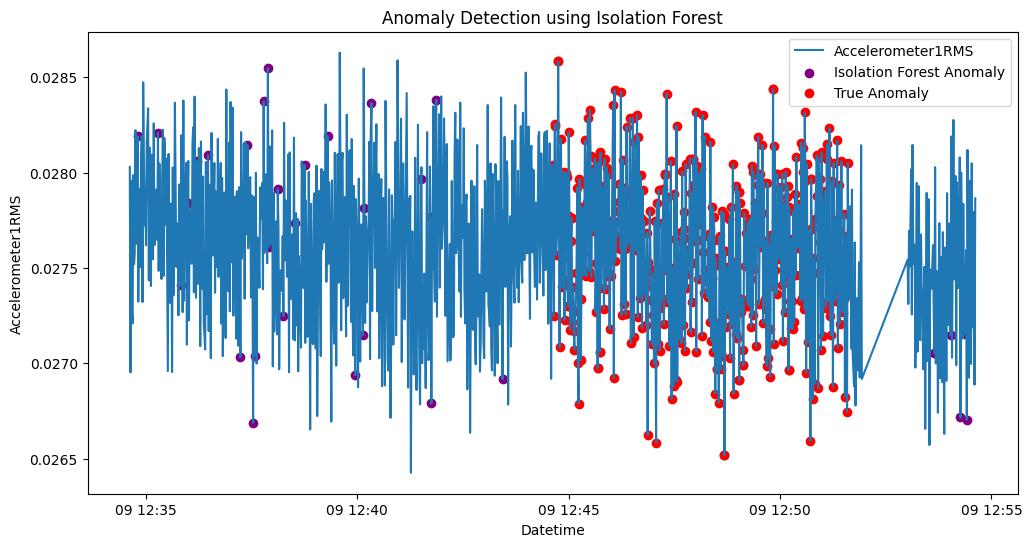

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Accelerometer1RMS'], label='Accelerometer1RMS')
plt.scatter(data[data['anomaly_iforest'] == 1].index,
            data[data['anomaly_iforest'] == 1]['Accelerometer1RMS'],
            color='purple', label='Isolation Forest Anomaly')
plt.scatter(data[data['anomaly'] == 1].index,
            data[data['anomaly'] == 1]['Accelerometer1RMS'],
            color='red', label='True Anomaly')
plt.xlabel('Datetime')
plt.ylabel('Accelerometer1RMS')
plt.legend()
plt.title('Anomaly Detection using Isolation Forest')
plt.show()

###Оцените качество, построив confusion matrix для предсказаний и исходных данных

Построим confusion matrix, чтобы оценить, насколько результаты модели совпадают с истинными аномалиями.

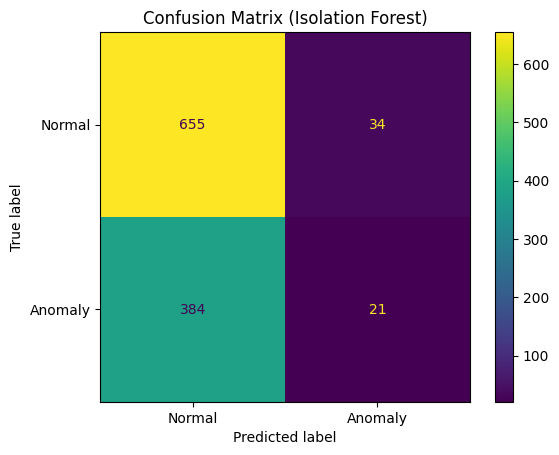

In [18]:
# Confusion matrix для Isolation Forest
cm_iforest = confusion_matrix(data['anomaly'], data['anomaly_iforest'])
ConfusionMatrixDisplay(cm_iforest, display_labels=['Normal', 'Anomaly']).plot()
plt.title('Confusion Matrix (Isolation Forest)')
plt.show()

Описание матрицы ошибок:

* True Negative (TN): 655 — количество правильно
предсказанных отрицательных случаев. Можно говорит о том, что это достаточно хорошие предсказания.

* False Positive (FP): 34 — количество неправильно предсказанных положительных случаев.

* False Negative (FN): 384 — количество неправильно предсказанных отрицательных случаев. Модель не обнаружила 384 случая, которые на самом деле положительные.

* True Positive (TP): 21 — количество правильно предсказанных положительных случаев.

Можно сделать вывод, что модель имеет низую точность, присутствует много ложноотрицательных ошибок.

In [19]:
third_report = classification_report(data['anomaly'], data['anomaly_iforest'],output_dict=True)
print(third_report)

{'0.0': {'precision': 0.6304138594802695, 'recall': 0.9506531204644412, 'f1-score': 0.7581018518518519, 'support': 689.0}, '1.0': {'precision': 0.38181818181818183, 'recall': 0.05185185185185185, 'f1-score': 0.09130434782608696, 'support': 405.0}, 'accuracy': 0.6179159049360147, 'macro avg': {'precision': 0.5061160206492257, 'recall': 0.5012524861581465, 'f1-score': 0.4247030998389694, 'support': 1094.0}, 'weighted avg': {'precision': 0.5383834669271201, 'recall': 0.6179159049360147, 'f1-score': 0.5112526844565733, 'support': 1094.0}}


###Соберите агрегированные результаты по всем экспериментам в отдельный датафрейм и сравните между собой, сделайте выводы

In [20]:
report_if = first_report
report_static = second_report
report_kmeans = third_report

# Преобразуем каждый отчет в DataFrame и добавляем название метода
df_report_if = pd.DataFrame(report_if).transpose().assign(Method="Isolation Forest")
df_report_static = pd.DataFrame(report_static).transpose().assign(Method="Static Method")
df_report_kmeans = pd.DataFrame(report_kmeans).transpose().assign(Method="KMeans")

# Объединяем отчеты в один DataFrame
df_comparison = pd.concat([df_report_if, df_report_static, df_report_kmeans], axis=0)

# Упорядочиваем столбцы для удобства
df_comparison = df_comparison.reset_index().rename(columns={'index': 'Metric'})
df_comparison = df_comparison[['Method', 'Metric', 'precision', 'recall', 'f1-score', 'support']]

# Выводим результирующий DataFrame для сравнения
print(df_comparison)

              Method        Metric  precision    recall  f1-score      support
0   Isolation Forest           0.0   0.629799  1.000000  0.772855   689.000000
1   Isolation Forest           1.0   0.000000  0.000000  0.000000   405.000000
2   Isolation Forest      accuracy   0.629799  0.629799  0.629799     0.629799
3   Isolation Forest     macro avg   0.314899  0.500000  0.386427  1094.000000
4   Isolation Forest  weighted avg   0.396647  0.629799  0.486743  1094.000000
5      Static Method           0.0   0.666090  0.562044  0.609660   685.000000
6      Static Method           1.0   0.414062  0.523457  0.462377   405.000000
7      Static Method      accuracy   0.547706  0.547706  0.547706     0.547706
8      Static Method     macro avg   0.540076  0.542750  0.536018  1090.000000
9      Static Method  weighted avg   0.572447  0.547706  0.554935  1090.000000
10            KMeans           0.0   0.630414  0.950653  0.758102   689.000000
11            KMeans           1.0   0.381818  0.051

#Выводы


Isolation Forest

Высокая точность (0.63) для класса 0, но нулевая для класса 1. Модель не распознаёт примеры класса 1. Общая точность – 0.63, макро- и взвешенные средние показатели низкие.

Static Method

Более высокая точность (0.67) для класса 0, чем у Isolation Forest, но низкая (0.41) для класса 1. Полнота для класса 1 (0.52) выше, чем у других моделей. Общая точность – 0.55, макропоказатели слабые.

KMeans

Точность для класса 0 (0.63) аналогична Isolation Forest, но очень низкая для класса 1 (0.38). Полнота для класса 1 крайне мала (0.05). Общая точность – 0.61, макропоказатели неудовлетворительные.

Все модели плохо справляются с распознаванием класса 1, вероятно из-за дисбаланса классов. Isolation Forest и KMeans совсем не выявляют примеры класса 1, Static Method работает лучше, но также далека от идеала.



